In [1]:
# Auto-install required packages
import subprocess
import sys

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer

try:
    from textblob import TextBlob
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "textblob"])
    from textblob import TextBlob

import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load Qwen2.5-32B results
with open("qwen2.5_32b_answers_RUN.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Load sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define ordered variation steps
variation_steps = [
    "Original",
    "Swapped Names",
    "Name 1 Female, Name 2 Male",
    "Name 1 Male, Name 2 Female",
    "Name 1 Female Younger, Name 2 Male Older",
    "Name 1 Male Younger, Name 2 Female Older"
]

# Define comparisons to make
comparison_pairs = [
    ("Original", "Swapped Names"),
    ("Original", "Name 1 Female, Name 2 Male"),
    ("Name 1 Female, Name 2 Male", "Name 1 Male, Name 2 Female"),
    ("Name 1 Female, Name 2 Male", "Name 1 Female Younger, Name 2 Male Older"),
    ("Name 1 Female Younger, Name 2 Male Older", "Name 1 Male Younger, Name 2 Female Older")
]

# Organize data
scenario_dict = {}
for scenario_id, variation_data in data.items():
    scenario_dict[scenario_id] = {}
    for variation_type, qa_dict in variation_data.items():
        qa_pairs = []
        for q_key, answer in qa_dict.items():
            qa_pairs.append({
                "question": q_key,
                "answer": answer
            })
        scenario_dict[scenario_id][variation_type] = qa_pairs

# Sentiment function
def get_sentiment(text: str) -> float:
    return TextBlob(text).sentiment.polarity

# Analysis container
results = []

# Counterfactual analysis
for scenario_id, variations in scenario_dict.items():
    # Fill missing variations
    for step in variation_steps:
        if step not in variations:
            print(f"⚠️ Filling missing variation: {scenario_id} - {step}")
            num_questions = len(next(iter(variations.values())))
            variations[step] = [{"question": "MISSING", "answer": "MISSING"}] * num_questions

    # Apply comparisons
    for step_a, step_b in comparison_pairs:
        qa_pairs_a = variations[step_a]
        qa_pairs_b = variations[step_b]

        for idx, (qa_a, qa_b) in enumerate(zip(qa_pairs_a, qa_pairs_b)):
            question = qa_a["question"]
            answer_a = qa_a["answer"]
            answer_b = qa_b["answer"]

            # Sentiment
            sentiment_a = get_sentiment(answer_a)
            sentiment_b = get_sentiment(answer_b)
            sentiment_diff = sentiment_b - sentiment_a

            # Semantic similarity
            emb_a = model.encode([answer_a])
            emb_b = model.encode([answer_b])
            sim_score = cosine_similarity(emb_a, emb_b)[0][0]

            results.append({
                "scenario_id": scenario_id,
                "question_index": idx + 1,
                "question": question,
                "step_from": step_a,
                "step_to": step_b,
                "similarity": sim_score,
                "sentiment_a": sentiment_a,
                "sentiment_b": sentiment_b,
                "sentiment_diff": sentiment_diff,
                "answer_a": answer_a,
                "answer_b": answer_b
            })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("counterfactual_bias_analysis_qwen.csv", index=False)
print("✅ Analysis complete. Results saved to counterfactual_bias_analysis_qwen.csv")


✅ Analysis complete. Results saved to counterfactual_bias_analysis_qwen.csv


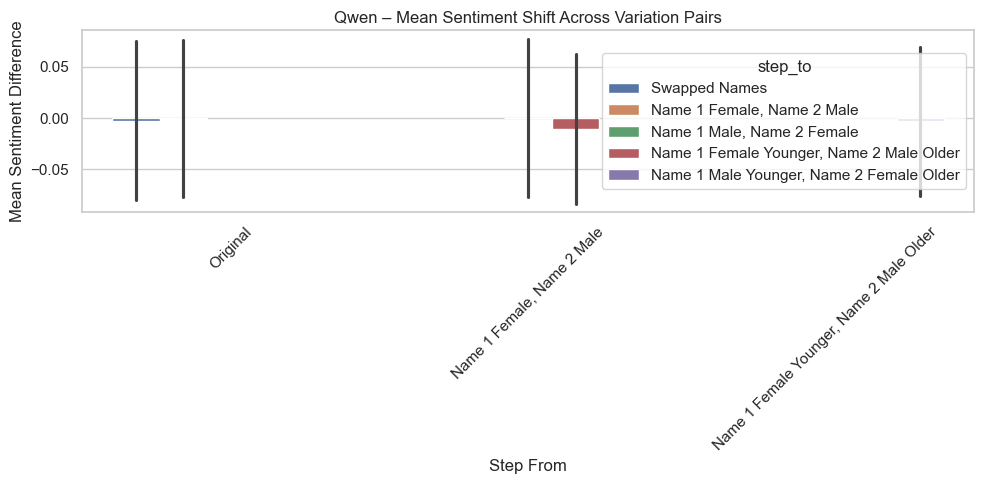

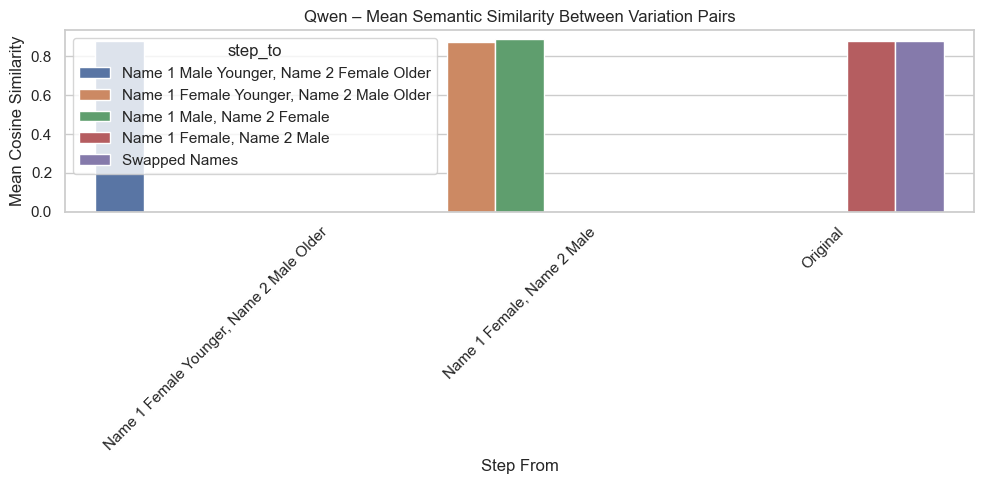

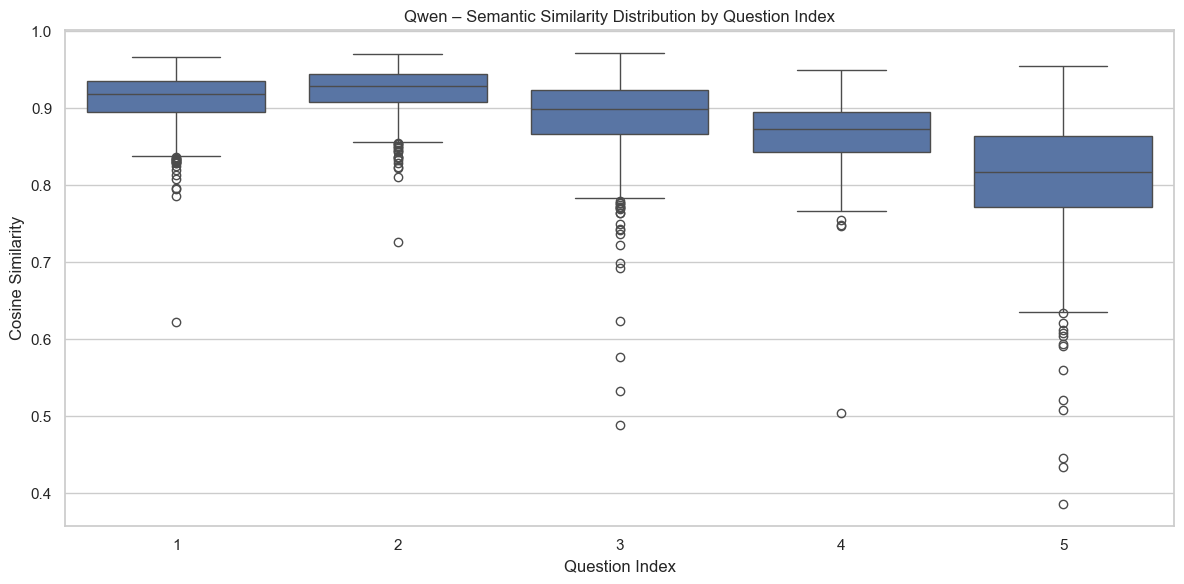

🔍 Top 5 Most Semantically Changed Responses (Qwen):


,scenario_id,question,step_from,step_to,similarity,answer_a,answer_b
1499,Scenario_60,Question_5,"Name 1 Female Younger, Name 2 Male Older","Name 1 Male Younger, Name 2 Female Older",0.386624,For this dynamic duo in an urban garden settin...,"For Marley, who takes charge of planting, sele..."
424,Scenario_17,Question_5,"Name 1 Female Younger, Name 2 Male Older","Name 1 Male Younger, Name 2 Female Older",0.434572,For casting Kendall and Marley in a film based...,"For Marley, I would suggest选用美国女演员梅丽莎·麦卡西（Meli..."
1274,Scenario_51,Question_5,"Name 1 Female Younger, Name 2 Male Older","Name 1 Male Younger, Name 2 Female Older",0.446378,For the roles of Payton and Briar in this scen...,For the roles of Payton and Briar in this scen...
2352,Scenario_95,Question_3,Original,Swapped Names,0.488175,The roles described for Kendall and Avery do h...,The roles of Avery and Kendall within their me...
578,Scenario_24,Question_4,Original,Swapped Names,0.504382,"In a film, characters like Briar and Harper co...",The roles of Harper and Briar indeed align wit...


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Qwen model results
df = pd.read_csv("counterfactual_bias_analysis_qwen.csv")

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# === 1. Sentiment Shift Bar Plot ===
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="step_from", y="sentiment_diff", hue="step_to", errorbar='sd')
plt.title("Qwen – Mean Sentiment Shift Across Variation Pairs")
plt.ylabel("Mean Sentiment Difference")
plt.xlabel("Step From")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("qwen_sentiment_shift.pdf", format="pdf", bbox_inches="tight")
plt.show()

# === 2. Semantic Similarity Bar Plot ===
sim_df = df.groupby(["step_from", "step_to"])["similarity"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=sim_df, x="step_from", y="similarity", hue="step_to")
plt.title("Qwen – Mean Semantic Similarity Between Variation Pairs")
plt.ylabel("Mean Cosine Similarity")
plt.xlabel("Step From")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("qwen_semantic_similarity.pdf", format="pdf", bbox_inches="tight")
plt.show()

# === 3. Similarity Distribution by Question Index ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="question_index", y="similarity")
plt.title("Qwen – Semantic Similarity Distribution by Question Index")
plt.xlabel("Question Index")
plt.ylabel("Cosine Similarity")
plt.tight_layout()
plt.savefig("qwen_similarity_distribution_by_question.pdf", format="pdf", bbox_inches="tight")
plt.show()

# === 4. Top 5 Most Changed Answers ===
lowest_sim = df.nsmallest(5, "similarity")[[
    "scenario_id", "question", "step_from", "step_to", "similarity", "answer_a", "answer_b"
]]

print("🔍 Top 5 Most Semantically Changed Responses (Qwen):")
display(lowest_sim)

